In [924]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ase import Atoms
from ase.io import read
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from ase.build import molecule
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import random
from torch_geometric.nn import global_add_pool, GATConv, CGConv
from torch_geometric.nn.models.schnet import GaussianSmearing
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt



# Data Preprocessing

In [968]:
def load_tox_csv(csv_path):
    labels_df = pd.read_csv(csv_path)
    return labels_df

In [969]:
tox_labels_df = load_tox_csv("../data/tox21/tox21_labels_train.csv")

In [866]:
print(tox_labels_df)

                  Name  NR.AhR  NR.AR  NR.AR.LBD  NR.Aromatase  NR.ER  \
0      NCGC00178831-03     NaN    NaN        NaN           NaN    NaN   
1      NCGC00166114-03     NaN    NaN        NaN           NaN    NaN   
2      NCGC00263563-01     NaN    NaN        NaN           NaN    NaN   
3      NCGC00013058-02     NaN    NaN        NaN           NaN    NaN   
4      NCGC00167516-01     NaN    0.0        NaN           NaN    NaN   
...                ...     ...    ...        ...           ...    ...   
12055  NCGC00261292-01     0.0    0.0        0.0           0.0    0.0   
12056  NCGC00261245-01     0.0    0.0        0.0           NaN    NaN   
12057  NCGC00260828-01     0.0    0.0        0.0           0.0    0.0   
12058  NCGC00260687-01     0.0    0.0        0.0           0.0    0.0   
12059  NCGC00261465-01     0.0    0.0        0.0           0.0    NaN   

       NR.ER.LBD  NR.PPAR.gamma  SR.ARE  SR.ATAD5  SR.HSE  SR.MMP  SR.p53  
0            NaN            NaN     NaN       N

In [927]:
for col in tox_labels_df.columns:
    print(tox_labels_df[col].value_counts())

NCGC00178831-03    1
NCGC00259216-01    1
NCGC00258611-01    1
NCGC00258865-01    1
NCGC00254127-01    1
                  ..
NCGC00166227-01    1
NCGC00181913-02    1
NCGC00090749-04    1
NCGC00259078-01    1
NCGC00261465-01    1
Name: Name, Length: 12060, dtype: int64
0.0    7460
1.0     981
Name: NR.AhR, dtype: int64
0.0    9271
1.0     383
Name: NR.AR, dtype: int64
0.0    8545
1.0     307
Name: NR.AR.LBD, dtype: int64
0.0    7062
1.0     378
Name: NR.Aromatase, dtype: int64
0.0    6998
1.0     964
Name: NR.ER, dtype: int64
0.0    8584
1.0     456
Name: NR.ER.LBD, dtype: int64
0.0    8214
1.0     237
Name: NR.PPAR.gamma, dtype: int64
0.0    6255
1.0    1146
Name: SR.ARE, dtype: int64
0.0    9000
1.0     363
Name: SR.ATAD5, dtype: int64
0.0    7979
1.0     438
Name: SR.HSE, dtype: int64
0.0    6378
1.0    1180
Name: SR.MMP, dtype: int64
0.0    8338
1.0     565
Name: SR.p53, dtype: int64


In [467]:
tox_labels_df['SR.ARE'].min()

0.0

In [970]:
tox_labels_df = tox_labels_df.fillna(1)

In [329]:
tox_labels_df.head()

,Name,NR.AhR,NR.AR,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
0,NCGC00178831-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NCGC00166114-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCGC00263563-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCGC00013058-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NCGC00167516-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [929]:
tox_labels_df = tox_labels_df.fillna(0)


#df_toxic = (tox_labels_df['SR.HSE']) > 0.0
df_toxic = tox_labels_df.iloc[:, 1:].sum(axis=1) > 0.0

new_df = pd.DataFrame({
    'Name': tox_labels_df['Name'],
    'toxicity': df_toxic.astype(int)
})

new_df.head()

,Name,toxicity
0,NCGC00178831-03,0
1,NCGC00166114-03,0
2,NCGC00263563-01,0
3,NCGC00013058-02,1
4,NCGC00167516-01,0


In [971]:
new_df['toxicity'].value_counts()

0    8200
1    3860
Name: toxicity, dtype: int64

In [714]:
def get_bond_type_one_hot(bond):
    bond_type_one_hot = [0, 0, 0, 0]

    if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
        bond_type_one_hot[0] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
        bond_type_one_hot[1] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.TRIPLE:
        bond_type_one_hot[2] = 1
    elif bond.GetBondType() == Chem.rdchem.BondType.AROMATIC:
        bond_type_one_hot[3] = 1

    return bond_type_one_hot

In [715]:
def check_num_elements(sdf_path):
    suppl = Chem.SDMolSupplier(sdf_path)


    elements = set()

    for mol in suppl:
        if mol is not None:
            for atom in mol.GetAtoms():
                elements.add(atom.GetAtomicNum())

    return elements

In [716]:
el = check_num_elements("../data/tox21/tox21.sdf")
print(el)

[19:15:55] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[19:15:55] ERROR: Could not sanitize molecule ending on line 21572
[19:15:55] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[19:15:56] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[19:15:56] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[19:15:56] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[19:15:56] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[19:15:58] Explicit valence for atom # 2 Si, 8, is greater than permitted
[19:15:58] ERROR: Could not sanitize molecule ending on line 346021
[19:15:58] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
[19:15:58] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[19:15:58] ERROR: Could not sanitize molecule ending on l

{1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 38, 40, 42, 44, 46, 47, 48, 49, 50, 51, 53, 56, 60, 63, 64, 66, 70, 78, 79, 80, 81, 82, 83}


[19:16:01] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
[19:16:01] ERROR: Could not sanitize molecule ending on line 980541
[19:16:01] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7
[19:16:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[19:16:01] ERROR: Could not sanitize molecule ending on line 982218
[19:16:01] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


In [718]:
atomic_to_index = {num: i for i, num in enumerate(sorted(el))}

In [719]:
print(atomic_to_index)

{1: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 11: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14, 19: 15, 20: 16, 21: 17, 22: 18, 23: 19, 24: 20, 25: 21, 26: 22, 27: 23, 28: 24, 29: 25, 30: 26, 32: 27, 33: 28, 34: 29, 35: 30, 38: 31, 40: 32, 42: 33, 44: 34, 46: 35, 47: 36, 48: 37, 49: 38, 50: 39, 51: 40, 53: 41, 56: 42, 60: 43, 63: 44, 64: 45, 66: 46, 70: 47, 78: 48, 79: 49, 80: 50, 81: 51, 82: 52, 83: 53}


In [855]:
node_dim = 100
bond_dim = 4
def load_data(sdf_path):
    graphs = []
    suppl = Chem.SDMolSupplier(sdf_path)


    datalist = []

    for mol in suppl:
        if mol is not None:
            positions = mol.GetConformer().GetPositions()
            positions_tensor = torch.tensor(positions, dtype=torch.float)
            atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
            x = torch.nn.functional.one_hot(torch.tensor(atomic_numbers)-1, num_classes=node_dim).float()

            name = mol.GetProp("_Name")

            properties = {}
            labels_bio = []
            labels_tox = []
            formula = Chem.rdMolDescriptors.CalcMolFormula(mol)

            for prop in mol.GetPropNames():
                properties[prop] = mol.GetProp(prop)
                if prop == "ReadyBiodegradability":
                    labels_bio.append(int(mol.GetProp(prop)))
                if prop == "SR-HSE":
                    labels_tox.append(int(mol.GetProp(prop)))


            labels_bio_tensor = torch.tensor(labels_bio, dtype=torch.int)
            labels_tox_tensor = torch.tensor(labels_tox, dtype=torch.int)

            atoms_list = []

            ase_atoms = Atoms(positions=positions, symbols=atomic_numbers)

            bonds = []
            bond_index = []
            edge_attr = []
            for bond in mol.GetBonds():
                bond_type = get_bond_type_one_hot(bond)
                bond_index.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
                bonds.append(bond_type)

            bond_index_tensor = torch.tensor(bond_index, dtype=torch.long)
            bonds_one_hot = torch.tensor(bonds, dtype=torch.float)



            anum = []
            degs = []
            chargs = []
            hybs = []
            hs = []
            elec = []
            aro = []
            rings = []

            for atom in mol.GetAtoms():
                anum.append(torch.nn.functional.one_hot(torch.tensor(atom.GetAtomicNum()), num_classes=node_dim))
                degs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetDegree()), num_classes=7))
                chargs.append(torch.tensor(atom.GetFormalCharge(), dtype=torch.int64))
                hybs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetHybridization()), num_classes=8))
                hs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetNumExplicitHs()), num_classes=6))

                elec.append(torch.tensor(atom.GetNumRadicalElectrons(), dtype=torch.int64))
                aro.append(torch.tensor(int(atom.GetIsAromatic())))
                rings.append(torch.tensor(int(atom.IsInRing())))




            anum = torch.stack(anum)
            degs = torch.stack(degs)
            chargs = torch.stack(chargs).unsqueeze(-1)
            hybs = torch.stack(hybs)
            hs = torch.stack(hs)
            elec = torch.stack(elec).unsqueeze(-1)
            aro = torch.stack(aro).unsqueeze(-1)
            rings = torch.stack(rings).unsqueeze(-1)
            atom_features = torch.cat([anum, degs, chargs, hybs, hs, elec, aro, rings], dim=1)


            charges = []
            for atom in mol.GetAtoms():
                atom_index = atom.GetIdx()
                symbol = atom.GetSymbol()
                formal_charge = atom.GetFormalCharge()
                atomic_number = atom.GetAtomicNum()
                atomic_mass = atom.GetMass()
                degree = atom.GetDegree()
                hybridization = atom.GetHybridization()
                num_explicit_hs = atom.GetNumExplicitHs()
                num_radical_electrons = atom.GetNumRadicalElectrons()
                is_aromatic = atom.GetIsAromatic()
                is_in_ring = atom.IsInRing()
                position = mol.GetConformer().GetAtomPosition(atom_index)
                charges.append(atom.GetFormalCharge())

                atoms_list.append({
                    "index": atom_index,
                    "symbol": symbol,
                    "formal_charge": formal_charge,
                    "atomic_number": atomic_number,
                    "atomic_mass": atomic_mass,
                    "hybridization": hybridization,
                    "num_explicit_hs": num_explicit_hs,
                    "num_radical_electrons": num_radical_electrons,
                    "is_aromatic": is_aromatic,
                    "is_in_ring": is_in_ring,
                    "position": position
                })

            edge_attr_list = []

            for batch in edge_attr:
                mini = []
                for entry in batch:
                    mini.append(torch.tensor(entry, dtype=torch.float))
                edge_attr_list.append(mini)

            d = Data(x=x)
            d.atom_data = atom_features
            d.formula = formula
            d.name = name
            d.positions = positions_tensor
            d.edge_index = bond_index_tensor.reshape((2, -1))
            d.edge_attr = bonds_one_hot
            d.bio = labels_bio_tensor
            d.tox = labels_tox_tensor
            datalist.append(d)

            # Create ASE atoms object
            graphs.append({
                "Atoms": atoms_list,
                "ASE_Atoms": ase_atoms,
                "Bonds": bonds,
                "Charges": charges,
                "Properties": properties
            })
    return graphs, datalist

In [495]:
node_dim = 54
bond_dim = 4
def load_data(sdf_path):
    graphs = []
    suppl = Chem.SDMolSupplier(sdf_path)


    datalist = []

    for mol in suppl:
        if mol is not None:
            positions = mol.GetConformer().GetPositions()
            positions_tensor = torch.tensor(positions, dtype=torch.float)
            atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
            #x = torch.nn.functional.one_hot(torch.tensor(atomic_numbers)-1, num_classes=node_dim).float()

            x = torch.zeros(len(atomic_numbers), node_dim)
            for i, num in enumerate(atomic_numbers):
                index = atomic_to_index.get(num)
                if index is not None:
                    x[i] = torch.nn.functional.one_hot(torch.tensor(index), num_classes=node_dim).float()

            name = mol.GetProp("_Name")

            properties = {}
            labels_bio = []
            labels_tox = []
            formula = Chem.rdMolDescriptors.CalcMolFormula(mol)

            for prop in mol.GetPropNames():
                properties[prop] = mol.GetProp(prop)
                if prop == "ReadyBiodegradability":
                    labels_bio.append(int(mol.GetProp(prop)))
                if prop == "SR-HSE":
                    labels_tox.append(int(mol.GetProp(prop)))


            labels_bio_tensor = torch.tensor(labels_bio, dtype=torch.int)
            labels_tox_tensor = torch.tensor(labels_tox, dtype=torch.int)

            atoms_list = []

            ase_atoms = Atoms(positions=positions, symbols=atomic_numbers)

            bonds = []
            bond_index = []
            edge_attr = []
            for bond in mol.GetBonds():
                start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                bond_type = get_bond_type_one_hot(bond)
                pos_start, pos_end = mol.GetConformer().GetAtomPosition(start), mol.GetConformer().GetAtomPosition(end)
                distance = np.linalg.norm(np.array(pos_start) - np.array(pos_end))
                edge_attr.extend([bond_type + [distance]])
                bond_index.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))

            bond_index_tensor = torch.tensor(bond_index, dtype=torch.long)
            #bonds_one_hot = torch.nn.functional.one_hot(torch.tensor(bonds, dtype=torch.long), num_classes=bond_dim).float()



            anum = []
            degs = []
            chargs = []
            hybs = []
            hs = []
            elec = []
            aro = []
            rings = []

            for atom in mol.GetAtoms():
                anum.append(torch.nn.functional.one_hot(torch.tensor(atomic_to_index.get(atom.GetAtomicNum())), num_classes=node_dim))
                degs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetDegree()), num_classes=7))
                chargs.append(torch.tensor(atom.GetFormalCharge(), dtype=torch.int64))
                hybs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetHybridization()), num_classes=8))
                hs.append(torch.nn.functional.one_hot(torch.tensor(atom.GetNumExplicitHs()), num_classes=6))

                elec.append(torch.tensor(atom.GetNumRadicalElectrons(), dtype=torch.int64))
                aro.append(torch.tensor(int(atom.GetIsAromatic())))
                rings.append(torch.tensor(int(atom.IsInRing())))


            anum = torch.stack(anum)
            degs = torch.stack(degs)
            chargs = torch.stack(chargs).unsqueeze(-1)
            hybs = torch.stack(hybs)
            hs = torch.stack(hs)
            elec = torch.stack(elec).unsqueeze(-1)
            aro = torch.stack(aro).unsqueeze(-1)
            rings = torch.stack(rings).unsqueeze(-1)
            atom_features = torch.cat([anum, degs, chargs, hybs, hs, elec, aro, rings], dim=1)


            charges = []
            for atom in mol.GetAtoms():
                atom_index = atom.GetIdx()
                symbol = atom.GetSymbol()
                formal_charge = atom.GetFormalCharge()
                atomic_number = atom.GetAtomicNum()
                atomic_mass = atom.GetMass()
                degree = atom.GetDegree()
                hybridization = atom.GetHybridization()
                num_explicit_hs = atom.GetNumExplicitHs()
                num_radical_electrons = atom.GetNumRadicalElectrons()
                is_aromatic = atom.GetIsAromatic()
                is_in_ring = atom.IsInRing()
                position = mol.GetConformer().GetAtomPosition(atom_index)
                charges.append(atom.GetFormalCharge())

                atoms_list.append({
                    "index": atom_index,
                    "symbol": symbol,
                    "formal_charge": formal_charge,
                    "atomic_number": atomic_number,
                    "atomic_mass": atomic_mass,
                    "hybridization": hybridization,
                    "num_explicit_hs": num_explicit_hs,
                    "num_radical_electrons": num_radical_electrons,
                    "is_aromatic": is_aromatic,
                    "is_in_ring": is_in_ring,
                    "position": position
                })

            edge_attr_list = []

            for batch in edge_attr:
                mini = []
                for entry in batch:
                    mini.append(torch.tensor(entry, dtype=torch.float))
                edge_attr_list.append(mini)

            d = Data(x=x)
            d.atom_data = atom_features
            d.formula = formula
            d.name = name
            d.positions = positions_tensor
            d.edge_index = bond_index_tensor.reshape((2, -1))
            d.edge_attr = torch.tensor(edge_attr_list)
            d.bio = labels_bio_tensor
            d.tox = labels_tox_tensor
            datalist.append(d)

            # Create ASE atoms object
            graphs.append({
                "Atoms": atoms_list,
                "ASE_Atoms": ase_atoms,
                "Bonds": bonds,
                "Charges": charges,
                "Properties": properties
            })
    return graphs, datalist

In [15]:
graphs_bio, datalist_bio = load_data("../data/AllPublicnew.sdf")


In [496]:
graphs_tox, datalist_tox = load_data("../data/tox21/tox21.sdf")

[15:34:18] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[15:34:18] ERROR: Could not sanitize molecule ending on line 21572
[15:34:18] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[15:44:32] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[15:44:32] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[15:44:32] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[15:44:32] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[15:52:16] Explicit valence for atom # 2 Si, 8, is greater than permitted
[15:52:16] ERROR: Could not sanitize molecule ending on line 346021
[15:52:16] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
[15:57:19] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[15:57:19] ERROR: Could not sanitize molecule ending on l

In [856]:
graphs_tox_1, datalist_tox_1 = load_data("../data/tox21/tox21.sdf")

[21:04:46] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[21:04:46] ERROR: Could not sanitize molecule ending on line 21572
[21:04:46] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[21:05:15] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[21:05:15] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[21:05:15] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[21:05:15] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[21:05:36] Explicit valence for atom # 2 Si, 8, is greater than permitted
[21:05:36] ERROR: Could not sanitize molecule ending on line 346021
[21:05:36] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
[21:05:48] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[21:05:48] ERROR: Could not sanitize molecule ending on l

In [857]:
print(len(datalist_tox_1))

12700


In [858]:
print(datalist_tox_1[9])

Data(x=[38, 100], atom_data=[38, 125], formula='C29H40Cl2FN3O3', name='NCGC00094089-01', positions=[38, 3], edge_index=[2, 39], edge_attr=[39, 4], bio=[0], tox=[0])


In [859]:
data_dict_list_1 = []

for data in datalist_tox_1:
    data_dict = {
        'id': data.name,
        'x': data.atom_data,
        'formula': data.formula,
        'positions': data.positions,
        'edge_index': data.edge_index,
        'edge_attr': data.edge_attr,
        'bio': data.bio,
        'tox': data.tox
    }
    data_dict_list_1.append(data_dict)

In [972]:
data_dict_list = []

for data in datalist_tox:
    data_dict = {
        'id': data.name,
        'x': data.atom_data,
        'formula': data.formula,
        'positions': data.positions,
        'edge_index': data.edge_index,
        'edge_attr': data.edge_attr,
        'bio': data.bio,
        'tox': data.tox
    }
    data_dict_list.append(data_dict)

In [973]:
tox_structure_df = pd.DataFrame(data_dict_list)
tox_structure_df.head()

,id,x,formula,positions,edge_index,edge_attr,bio,tox
0,NCGC00178831-03,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C27H25ClN6,"[[tensor(4.8814), tensor(-2.7443), tensor(0.)]...","[[tensor(1), tensor(2), tensor(2), tensor(3), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]"
1,NCGC00166114-03,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C20H6Br4Na2O5,"[[tensor(4.9884), tensor(-1.2417), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(14),...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]"
2,NCGC00263563-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C47H83NO17,"[[tensor(2.1953), tensor(-4.9878), tensor(0.)]...","[[tensor(0), tensor(2), tensor(0), tensor(5), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]"
3,NCGC00013058-02,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C52H54N4O12,"[[tensor(6.7770), tensor(-3.4336), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(2), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(1, dtype=torch.int32)]"
4,NCGC00167516-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C66H87N17O14,"[[tensor(2.0392), tensor(-0.7005), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(2), ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(1...",[],[]


### For 12 Tox

In [974]:
merged_12 = pd.merge(tox_structure_df, tox_labels_df, left_on='id', right_on='Name', how='inner')
print(len(merged_12))


11759


In [270]:
check = merged_12["formula"].value_counts()

filtered_counts = check[check > 1]
print(filtered_counts)

C10H18O          32
C10H14O          30
C8H10O           25
C10H16           24
C10H20O          24
                 ..
C8H11NO4S2        2
C23H29ClFN3O4     2
C14H8O2           2
C20H27Cl2NO5      2
C3H6ClNO          2
Name: formula, Length: 2841, dtype: int64


In [975]:
merged_12 = merged_12.sort_values(by=["NR.AhR","NR.AR","NR.AR.LBD","NR.Aromatase","NR.ER","NR.ER.LBD","NR.PPAR.gamma","SR.ARE","SR.ATAD5","SR.HSE","SR.MMP","SR.p53"], ascending=True)

merged_12 = merged_12.drop_duplicates(subset='formula', keep='last')
merged_12.head()

,id,x,formula,positions,edge_index,edge_attr,bio,tox,Name,NR.AhR,...,NR.AR.LBD,NR.Aromatase,NR.ER,NR.ER.LBD,NR.PPAR.gamma,SR.ARE,SR.ATAD5,SR.HSE,SR.MMP,SR.p53
7794,NCGC00254768-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C8H6N2OS2,"[[tensor(0.), tensor(-2.8854), tensor(0.)], [t...","[[tensor(0), tensor(1), tensor(1), tensor(2), ...","[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00254768-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8248,NCGC00260253-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C7H16BrN,"[[tensor(2.6307), tensor(-2.5031), tensor(0.)]...","[[tensor(0), tensor(2), tensor(1), tensor(7), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00260253-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8250,NCGC00260212-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C10H22BrN,"[[tensor(3.8043), tensor(-3.9098), tensor(0.)]...","[[tensor(0), tensor(2), tensor(1), tensor(10),...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00260212-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8261,NCGC00182994-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C22H28INO2,"[[tensor(3.8094), tensor(-3.9247), tensor(0.)]...","[[tensor(0), tensor(2), tensor(0), tensor(24),...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00182994-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9081,NCGC00256023-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C11H18O,"[[tensor(1.4316), tensor(-1.2317), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(5), ...","[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00256023-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [976]:
print(merged_12['NR.AR.LBD'].value_counts())

0.0    3230
1.0    2622
Name: NR.AR.LBD, dtype: int64


In [336]:
print(len(merged_12))

5852


In [977]:
datalist_toxicity_12 = []
truth_list = []
for index, row in merged_12.iterrows():
    #print(row["NR.AhR"],row["NR.AR"],row["NR.AR.LBD"],row["NR.Aromatase"],row["NR.ER"],row["NR.ER.LBD"],row["NR.PPAR.gamma"],row["SR.ARE"],row["SR.ATAD5"],row["SR.HSE"],row["SR.MMP"],row["SR.p53"])
    truth_list = [row["NR.AhR"],row["NR.AR"],row["NR.AR.LBD"],row["NR.Aromatase"],row["NR.ER"],row["NR.ER.LBD"],row["NR.PPAR.gamma"],row["SR.ARE"],row["SR.ATAD5"],row["SR.HSE"],row["SR.MMP"],row["SR.p53"]]
    #truth_list = [tensor.unsqueeze(0) for tensor in truth_list]
    data = Data(x=row['x'], positions=row['positions'], edge_index=row['edge_index'], edge_attr=row['edge_attr'], bio=row['bio'], tox=torch.tensor(truth_list, dtype=torch.int64))
    datalist_toxicity_12.append(data)

In [735]:
print(datalist_toxicity_12[5000].positions)

tensor([[ 4.2025, -2.2274,  0.0000],
        [ 3.4697, -1.9799,  0.0000],
        [ 3.4697, -1.1792,  0.0000],
        [ 4.2025, -0.9463,  0.0000],
        [ 4.6683, -1.5869,  0.0000],
        [ 2.7564, -0.7813,  0.0000],
        [ 2.7564, -2.3827,  0.0000],
        [ 2.0867, -1.1792,  0.0000],
        [ 2.0867, -1.9799,  0.0000],
        [ 2.7564,  0.0000,  0.0000],
        [ 4.1733, -3.4017,  0.0000],
        [ 2.8485, -3.4017,  0.0000],
        [ 3.5085, -2.9068,  0.0000],
        [ 3.1009, -4.1928,  0.0000],
        [ 3.9259, -4.1928,  0.0000],
        [ 2.6156, -4.8527,  0.0000],
        [ 4.3966, -4.8527,  0.0000],
        [ 2.0430, -3.1348,  0.0000],
        [ 1.4364, -3.7026,  0.0000],
        [ 0.0000, -3.7026,  0.0000],
        [ 0.7134, -3.2853,  0.0000],
        [ 0.7134, -2.4652,  0.0000],
        [ 0.3155, -4.1102,  0.0000]])


In [978]:
print(datalist_toxicity_12)

[Data(x=[13, 79], edge_index=[2, 14], edge_attr=[14, 5], positions=[13, 3], bio=[0], tox=[12]), Data(x=[9, 79], edge_index=[2, 8], edge_attr=[8, 5], positions=[9, 3], bio=[0], tox=[12]), Data(x=[12, 79], edge_index=[2, 11], edge_attr=[11, 5], positions=[12, 3], bio=[0], tox=[12]), Data(x=[26, 79], edge_index=[2, 28], edge_attr=[28, 5], positions=[26, 3], bio=[0], tox=[12]), Data(x=[12, 79], edge_index=[2, 12], edge_attr=[12, 5], positions=[12, 3], bio=[0], tox=[12]), Data(x=[25, 79], edge_index=[2, 22], edge_attr=[22, 5], positions=[25, 3], bio=[0], tox=[12]), Data(x=[4, 79], edge_index=[2, 3], edge_attr=[3, 5], positions=[4, 3], bio=[0], tox=[12]), Data(x=[21, 79], edge_index=[2, 20], edge_attr=[20, 5], positions=[21, 3], bio=[0], tox=[12]), Data(x=[5, 79], edge_index=[2, 4], edge_attr=[4, 5], positions=[5, 3], bio=[0], tox=[12]), Data(x=[25, 79], edge_index=[2, 27], edge_attr=[27, 5], positions=[25, 3], bio=[0], tox=[12]), Data(x=[31, 79], edge_index=[2, 33], edge_attr=[33, 5], posit

### For 1 Tox

In [933]:
merged_df = pd.merge(tox_structure_df, new_df, left_on='id', right_on='Name', how='inner')
print(len(merged_df))


11759


In [198]:
check = merged_df["formula"].value_counts()

filtered_counts = check[check > 1]
print(filtered_counts)

C10H18O          32
C10H14O          30
C8H10O           25
C10H16           24
C10H20O          24
                 ..
C8H11NO4S2        2
C23H29ClFN3O4     2
C14H8O2           2
C20H27Cl2NO5      2
C3H6ClNO          2
Name: formula, Length: 2841, dtype: int64


In [199]:
print(len(merged_df))

11759


In [934]:
merged_df = merged_df.sort_values(by='toxicity', ascending=True)

merged_df = merged_df.drop_duplicates(subset='formula', keep='last')

In [935]:
print(len(merged_df))

5852


In [936]:
print(merged_df['toxicity'].value_counts())

0    3327
1    2525
Name: toxicity, dtype: int64


In [937]:
merged_df.head()


,id,x,formula,positions,edge_index,edge_attr,bio,tox,Name,toxicity
7694,NCGC00260160-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C6H12S2,"[[tensor(2.8578), tensor(-0.4104), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(5), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00260160-01,0
7696,NCGC00254788-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C11H21NOS,"[[tensor(2.1454), tensor(-0.8148), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(3), ...","[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00254788-01,0
7699,NCGC00255962-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C11H26O3Si,"[[tensor(2.0572), tensor(-2.0679), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(2), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00255962-01,0
7701,NCGC00257980-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C8H20O4Si,"[[tensor(2.0625), tensor(-2.0625), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(4), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00257980-01,0
7702,NCGC00247689-01,"[[tensor(0), tensor(0), tensor(0), tensor(0), ...",C21H27ClN2O,"[[tensor(5.7738), tensor(-1.2367), tensor(0.)]...","[[tensor(0), tensor(1), tensor(0), tensor(4), ...","[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",[],"[tensor(0, dtype=torch.int32)]",NCGC00247689-01,0


In [874]:
print(merged_df.isnull().any(axis=1).sum())

0


In [654]:
merged_df['toxicity'].value_counts()

0    3327
1    2525
Name: toxicity, dtype: int64

In [938]:
datalist_toxicity = []

for index, row in merged_df.iterrows():
    data = Data(x=row['x'], positions=row['positions'], edge_index=row['edge_index'], edge_attr=row['edge_attr'], bio=row['bio'], tox=torch.tensor([row['toxicity']], dtype=torch.int64))
    datalist_toxicity.append(data)

In [939]:
print(datalist_toxicity)

[Data(x=[8, 79], edge_index=[2, 7], edge_attr=[7, 5], positions=[8, 3], bio=[0], tox=[1]), Data(x=[14, 79], edge_index=[2, 14], edge_attr=[14, 5], positions=[14, 3], bio=[0], tox=[1]), Data(x=[15, 79], edge_index=[2, 14], edge_attr=[14, 5], positions=[15, 3], bio=[0], tox=[1]), Data(x=[13, 79], edge_index=[2, 12], edge_attr=[12, 5], positions=[13, 3], bio=[0], tox=[1]), Data(x=[25, 79], edge_index=[2, 26], edge_attr=[26, 5], positions=[25, 3], bio=[0], tox=[1]), Data(x=[3, 79], edge_index=[2, 1], edge_attr=[1, 5], positions=[3, 3], bio=[0], tox=[1]), Data(x=[6, 79], edge_index=[2, 5], edge_attr=[5, 5], positions=[6, 3], bio=[0], tox=[1]), Data(x=[11, 79], edge_index=[2, 10], edge_attr=[10, 5], positions=[11, 3], bio=[0], tox=[1]), Data(x=[11, 79], edge_index=[2, 10], edge_attr=[10, 5], positions=[11, 3], bio=[0], tox=[1]), Data(x=[7, 79], edge_index=[2, 7], edge_attr=[7, 5], positions=[7, 3], bio=[0], tox=[1]), Data(x=[14, 79], edge_index=[2, 14], edge_attr=[14, 5], positions=[14, 3], 

### Visualization of Our Data Object

In [60]:
print("Tox Data Object: ", datalist_tox)
print("--------------------------------------------------")
print("Biodegradability Data Object: ", datalist_bio)

Tox Data Object:  [Data(x=[34, 100], atom_data=[34, 125], formula='C27H25ClN6', name='NCGC00178831-03', positions=[34, 3], edge_index=[2, 37], edge_attr=[37, 4], bio=[0], tox=[1]), Data(x=[31, 100], atom_data=[31, 125], formula='C20H6Br4Na2O5', name='NCGC00166114-03', positions=[31, 3], edge_index=[2, 32], edge_attr=[32, 4], bio=[0], tox=[1]), Data(x=[65, 100], atom_data=[65, 125], formula='C47H83NO17', name='NCGC00263563-01', positions=[65, 3], edge_index=[2, 70], edge_attr=[70, 4], bio=[0], tox=[1]), Data(x=[68, 100], atom_data=[68, 125], formula='C52H54N4O12', name='NCGC00013058-02', positions=[68, 3], edge_index=[2, 69], edge_attr=[69, 4], bio=[0], tox=[1]), Data(x=[97, 100], atom_data=[97, 125], formula='C66H87N17O14', name='NCGC00167516-01', positions=[97, 3], edge_index=[2, 103], edge_attr=[103, 4], bio=[0], tox=[0]), Data(x=[23, 100], atom_data=[23, 125], formula='C20H35NOS', name='NCGC00018301-05', positions=[23, 3], edge_index=[2, 23], edge_attr=[23, 4], bio=[0], tox=[1]), Da

NameError: name 'datalist_bio' is not defined

In [26]:
# Comment for Amish: once you are finished with the join, can you replace these two lines with just one saving the combined datalist?
torch.save(datalist_bio, '../data/datalist_bio.pt')
torch.save(datalist_tox, '../data/datalist_tox.pt')

### Example of Toxicity vs Biodegradability Full Data 

In [27]:
print("Tox Graphs Data: ",graphs_tox[0])
print("--------------------------------------------------")
print("Bio Graphs Data: ", graphs_bio[0])

Tox Graphs Data:  {'Atoms': [{'index': 0, 'symbol': 'Cl', 'formal_charge': -1, 'atomic_number': 17, 'atomic_mass': 35.453, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'num_explicit_hs': 0, 'num_radical_electrons': 0, 'is_aromatic': False, 'is_in_ring': False, 'position': <rdkit.Geometry.rdGeometry.Point3D object at 0x173990cc0>}, {'index': 1, 'symbol': 'C', 'formal_charge': 0, 'atomic_number': 6, 'atomic_mass': 12.011, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'num_explicit_hs': 0, 'num_radical_electrons': 0, 'is_aromatic': False, 'is_in_ring': False, 'position': <rdkit.Geometry.rdGeometry.Point3D object at 0x173996940>}, {'index': 2, 'symbol': 'N', 'formal_charge': 1, 'atomic_number': 7, 'atomic_mass': 14.007, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP2, 'num_explicit_hs': 0, 'num_radical_electrons': 0, 'is_aromatic': True, 'is_in_ring': True, 'position': <rdkit.Geometry.rdGeometry.Point3D object at 0x175256440>}, {'index': 3, 'symbol': 'C', 

In [28]:
print("Toxicity Data Size: ", len(graphs_tox))
print("Biodegradability Data Size: ", len(graphs_bio))

Toxicity Data Size:  12700
Biodegradability Data Size:  3192


# Toxicity Evaluation Model

### Spliting Data For Toxicity Evaluation Model

In [979]:
batch_size = 32

In [287]:
print(len(datalist_toxicity_12))

5852


In [940]:
toxic_samples = [data for data in datalist_toxicity if data.tox == 1]
non_toxic_samples = [data for data in datalist_toxicity if data.tox == 0]

target_size = 4000
random_indices = np.random.choice(len(toxic_samples), size=target_size, replace=True)
balanced_toxic_samples = [toxic_samples[i] for i in random_indices]


random_indices_non = np.random.choice(len(non_toxic_samples), size=target_size, replace=True)
balanced_non_toxic_samples = [non_toxic_samples[i] for i in random_indices_non]

print(len(balanced_non_toxic_samples), len(balanced_toxic_samples))

balanced_dataset = balanced_non_toxic_samples + balanced_toxic_samples

np.random.shuffle(balanced_dataset)


4000 4000


In [948]:
toxic_new = [data for data in balanced_dataset if data.tox == 1]
non_toxic_new = [data for data in balanced_dataset if data.tox == 0]

print(len(toxic_new), len(non_toxic_new))

4000 4000


In [949]:
train_data, test_data = train_test_split(balanced_dataset, test_size=0.2, random_state=42)

### For 12


In [482]:
torch.save(datalist_toxicity_12, "../data/datalist_12tox.pt")

In [1023]:
print(len(datalist_toxicity_12))

5852


In [1025]:
train_data, test_data = train_test_split(datalist_toxicity_12, test_size=0.2, random_state=49)

In [1039]:
batch_size = 1

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [1029]:
print(len(train_loader))

1561


In [1022]:
for b in train_loader:
    print(b)

DataBatch(x=[725, 79], edge_index=[2, 742], edge_attr=[742, 5], positions=[725, 3], bio=[0], tox=[384], batch=[725], ptr=[33])
DataBatch(x=[712, 79], edge_index=[2, 748], edge_attr=[748, 5], positions=[712, 3], bio=[0], tox=[384], batch=[712], ptr=[33])


DataBatch(x=[688, 79], edge_index=[2, 715], edge_attr=[715, 5], positions=[688, 3], bio=[0], tox=[384], batch=[688], ptr=[33])
DataBatch(x=[545, 79], edge_index=[2, 548], edge_attr=[548, 5], positions=[545, 3], bio=[0], tox=[384], batch=[545], ptr=[33])
DataBatch(x=[599, 79], edge_index=[2, 614], edge_attr=[614, 5], positions=[599, 3], bio=[0], tox=[384], batch=[599], ptr=[33])
DataBatch(x=[635, 79], edge_index=[2, 655], edge_attr=[655, 5], positions=[635, 3], bio=[0], tox=[384], batch=[635], ptr=[33])
DataBatch(x=[517, 79], edge_index=[2, 522], edge_attr=[522, 5], positions=[517, 3], bio=[0], tox=[384], batch=[517], ptr=[33])
DataBatch(x=[712, 79], edge_index=[2, 732], edge_attr=[732, 5], positions=[712, 3], bio=[0], tox=[384], batch=[712], ptr=[33])
DataBatch(x=[723, 79], edge_index=[2, 740], edge_attr=[740, 5], positions=[723, 3], bio=[0], tox=[384], batch=[723], ptr=[33])
DataBatch(x=[596, 79], edge_index=[2, 619], edge_attr=[619, 5], positions=[596, 3], bio=[0], tox=[384], batch=[

## Model

In [390]:

##class GraphConvolution(MessagePassing):
##    def __init__(self, in_channels, out_channels):
##        super(GraphConvolution, self).__init__(aggr='add')
##        self.lin = nn.Linear(in_channels, out_channels)

##    def forward(self, x, edge_index, edge_attr):
##        return super(GraphConvolution, self).propagate(edge_index, x=x, edge_attr=edge_attr)

##    def message(self, x_j):
##        return x_j

##    def update(self, aggr_out):
##        return self.lin(aggr_out)

#cutoff = 8.0
#edge_dim = 50

#class GraphEncoder(nn.Module):
#    def __init__(self, input_dim, hidden_dim, num_heads):
#        super(GraphEncoder, self).__init__()
#        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads)
#        #self.conv3 = CGConv(hidden_dim * num_heads, edge_dim)
#        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
#        self.dropout = nn.Dropout(0.3)
#        self.batch = nn.BatchNorm1d(hidden_dim * num_heads)

#    def forward(self, x, edge_index, edge_attr, positions):
#        x = self.conv1(x, edge_index, edge_attr)
#        x = nn.ReLU()(x)
#        x = self.dropout(x)
#        x = self.batch(x)
#        #x = self.conv3(x, edge_index, edge_attr)
#        #x = nn.ReLU()(x)
#        #x = self.dropout(x)
#        #x = self.batch(x)
#        return x

#class ToxicClassifier(nn.Module):
#    def __init__(self, input_dim, hidden_dim, num_heads):
#        super(ToxicClassifier, self).__init__()
#        self.pre_graph = [
#            nn.Linear(input_dim, input_dim),
#            nn.ReLU(),
#            #nn.Linear(hidden_dim, ),
#            #nn.ReLU(),
#        ]
#        self.encoder = GraphEncoder(input_dim, hidden_dim, num_heads)
#        self.fc = nn.Linear(hidden_dim * num_heads, 12)

#    def forward(self, data):
#        x, edge_index, edge_attr, positions = data.x, data.edge_index, data.edge_attr, data.positions
#        x = x.float()
#        for layer in self.pre_graph:
#            x = layer(x)

#        x = self.encoder(x, edge_index,edge_attr, positions)
#        x = global_add_pool(x, data.batch)
#        x = self.fc(x)
#        x = torch.sigmoid(x)
#        return x.squeeze(dim=1)

## Model 72

In [1048]:

cutoff = 8.0
edge_dim = 50
node_dim = 54

class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(GraphEncoder, self).__init__()
        self.conv1 = GATConv(input_dim+25, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.conv3 = CGConv(input_dim+25, edge_dim)
        self.dropout = nn.Dropout(0.4)
        self.batch = nn.BatchNorm1d(hidden_dim*num_heads)

    def forward(self, x, edge_index, edge_attr, positions):
        #x = torch.cat([x, positions], dim=1)
        x = self.conv1(x, edge_index, edge_attr)
        x = nn.GELU()(x)
        x = self.dropout(x)
        x = self.batch(x)
        #x = self.conv2(x, edge_index, edge_attr)
        #x = nn.ReLU()(x)
        #x = self.dropout(x)
        #x = self.batch(x)
        #x = self.conv3(x, edge_index, edge_attr)
        #x = nn.ReLU()(x)
        #x = self.dropout(x)
        #x = self.batch(x)
        return x

class ToxicClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(ToxicClassifier, self).__init__()
        self.pre_graph = [
            nn.Linear(input_dim+25, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim+25),
            nn.ReLU(),
        ]
        self.encoder = GraphEncoder(input_dim, hidden_dim, num_heads)
        self.fc = nn.Linear(hidden_dim * num_heads, 12)

    def forward(self, data):
        x, edge_index, edge_attr, positions = data.x, data.edge_index, data.edge_attr, data.positions
        x = x.float()

        #gaussian_smearing = GaussianSmearing(0.0, cutoff, edge_dim)

        #row, col = edge_index
        #edge_distances = torch.norm(positions[row] - positions[col], dim=1)
        #edge_attr = torch.cat([edge_attr, gaussian_smearing(edge_distances)], dim=1)

        #for layer in self.pre_graph:
        #    x = layer(x)
        x = self.encoder(x, edge_index, edge_attr, positions)
        x = global_add_pool(x, data.batch)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x.squeeze(dim=1)

### Initialization and Training

In [1045]:
# Initialize model
hidden_dim = 2
model = ToxicClassifier(node_dim, hidden_dim, 2)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [1021]:
print(len(train_loader))

147


In [985]:
count_0 = 0
count_1 = 0
for b in train_loader:
    for d in b.tox:
        if d == 0:
            count_0 += 1
        if d == 1:
            count_1 += 1

print(count_0, count_1)

29739 26433


### Train 12


In [1046]:
# Train model
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    model.train()
    for graph in train_loader:
        optimizer.zero_grad()
        output = model(graph)
        loss = criterion(output.to(torch.float), (graph.tox.reshape(-1,12)).to(torch.float))
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        #scheduler.step()

    if epoch % 10 == 0:
        losses.append(loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')



Epoch 1/10, Loss: 0.674612283706665
Epoch 2/10, Loss: 0.7325243949890137
Epoch 3/10, Loss: 0.6746123433113098
Epoch 4/10, Loss: 0.742004930973053
Epoch 5/10, Loss: 0.7150700688362122
Epoch 6/10, Loss: 0.6716246604919434
Epoch 7/10, Loss: 0.722245454788208
Epoch 8/10, Loss: 0.6688562035560608
Epoch 9/10, Loss: 0.7004426121711731
Epoch 10/10, Loss: 0.6688563227653503


In [1047]:
# Evaluate model
model.eval()

y_true = []
y_pred = []

correct_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0}
num_0 = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0}
num_1 = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0}


num_0_pred = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0}
num_1_pred = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0}



num_9_0s = 0
num_9_1s = 0

correct = 0
total = 0
total_graphs = len(test_data)
print(total_graphs)

with torch.no_grad():
    for graph in test_data:
        output = model(graph)
        predicted = torch.round(output)
        y_true.append((graph.tox).to(torch.int).view(-1, 12)[0])
        y_pred.append(predicted.to(torch.int)[0])
        for i in range(12):
            if int(predicted[0][i]) == int(graph.tox.view(-1,12)[0][i]):
                correct += 1
                correct_dict[i] += 1
            total += 1

            if int(graph.tox.view(-1,12)[0][i]) == 0:
                num_0[i] += 1
            elif int(graph.tox.view(-1,12)[0][i]) == 1:
                num_1[i] += 1

            if int(predicted[0][i]) == 0:
                num_0_pred[i] += 1
            elif int(predicted[0][i]) == 1:
                num_1_pred[i] += 1

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')

print(correct_dict)

for k,v in correct_dict.items():
    acc = v / (total_graphs)
    print(f'Accuracy for {k}: {acc}')


print("Number of 0's In Truth: ", num_0)
print("Number of 0's Predicted: ", num_0_pred)
print("Number of 1's In Truth: ", num_1)
print("Number of 1's Predicted: ", num_1_pred)



1171
Accuracy: 0.532095075434102
{0: 544, 1: 718, 2: 659, 3: 642, 4: 500, 5: 619, 6: 629, 7: 638, 8: 470, 9: 846, 10: 683, 11: 529}
Accuracy for 0: 0.4645602049530316
Accuracy for 1: 0.6131511528608027
Accuracy for 2: 0.5627668659265584
Accuracy for 3: 0.5482493595217762
Accuracy for 4: 0.4269854824935952
Accuracy for 5: 0.5286080273270709
Accuracy for 6: 0.5371477369769427
Accuracy for 7: 0.5448334756618275
Accuracy for 8: 0.4013663535439795
Accuracy for 9: 0.7224594363791631
Accuracy for 10: 0.5832621690862511
Accuracy for 11: 0.4517506404782237
Number of 0's In Truth:  {0: 544, 1: 723, 2: 659, 3: 529, 4: 500, 5: 660, 6: 629, 7: 639, 8: 701, 9: 846, 10: 488, 11: 642}
Number of 0's Predicted:  {0: 1171, 1: 1166, 2: 1171, 3: 0, 4: 1171, 5: 1110, 6: 1171, 7: 1170, 8: 0, 9: 1171, 10: 0, 11: 0}
Number of 1's In Truth:  {0: 627, 1: 448, 2: 512, 3: 642, 4: 671, 5: 511, 6: 542, 7: 532, 8: 470, 9: 325, 10: 683, 11: 529}
Number of 1's Predicted:  {0: 0, 1: 5, 2: 0, 3: 1171, 4: 0, 5: 61, 6: 0, 

In [86]:
print(y_true)
print(y_pred)

[tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32), tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.int32), tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0], dtype=torch.int32), tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=torch.int32), tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=torch.int32), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=torch.int32), tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1], dtype=torch.int32), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32), tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=torch.int32), tensor([1, 1, 1, 1, 1, 1

In [774]:
auc_roc = roc_auc_score(y_true, y_pred)
print("ROC AUC Score:", auc_roc)

ROC AUC Score: 0.529942355138464


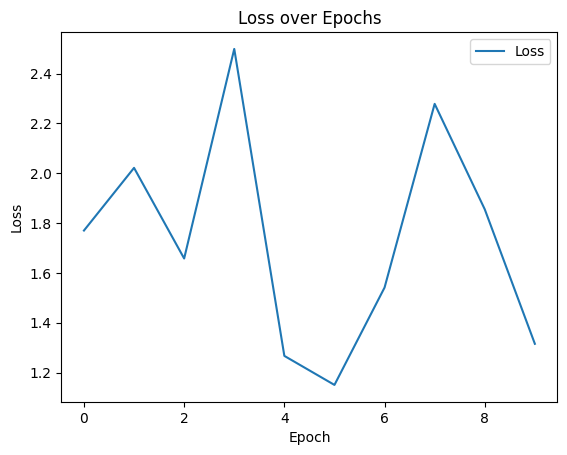

In [777]:
loss_list=[]
for i in losses:
    loss_list.append(i)

epochs = range(0, 10)

plt.plot(epochs, loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

### Train 1

In [666]:
for p in model.parameters():
    p.requires_grad = True

In [966]:
# Train model
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    model.train()
    for graph in train_loader:
        optimizer.zero_grad()
        output = model(graph)

        loss = criterion(output.to(torch.float), (graph.tox).to(torch.float))
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        #scheduler.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    if epoch % 5 == 0:
        losses.append(loss.item())


Epoch 1/200, Loss: 1.8634341955184937
Epoch 2/200, Loss: 1.338301420211792
Epoch 3/200, Loss: 0.9880523085594177
Epoch 4/200, Loss: 1.2762441635131836
Epoch 5/200, Loss: 1.390620470046997
Epoch 6/200, Loss: 1.4042658805847168
Epoch 7/200, Loss: 1.2350126504898071
Epoch 8/200, Loss: 1.4238377809524536
Epoch 9/200, Loss: 1.195231318473816
Epoch 10/200, Loss: 1.4852101802825928
Epoch 11/200, Loss: 1.399287223815918
Epoch 12/200, Loss: 1.1335233449935913
Epoch 13/200, Loss: 0.6833254098892212
Epoch 14/200, Loss: 1.2432767152786255
Epoch 15/200, Loss: 1.1122993230819702
Epoch 16/200, Loss: 1.009840965270996
Epoch 17/200, Loss: 1.486863136291504
Epoch 18/200, Loss: 1.1125085353851318
Epoch 19/200, Loss: 1.1984151601791382
Epoch 20/200, Loss: 1.0734243392944336
Epoch 21/200, Loss: 1.3820230960845947
Epoch 22/200, Loss: 4.099825382232666
Epoch 23/200, Loss: 1.4446136951446533
Epoch 24/200, Loss: 0.9995530843734741
Epoch 25/200, Loss: 1.392009973526001
Epoch 26/200, Loss: 0.8467239737510681
Epo

In [967]:
# Evaluate model
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    correct_0s = 0
    correct_1s = 0
    total_1s = 0
    total_0s = 0
    total = 0
    tote_0 = 0
    tote_1 = 0
    for graph in test_data:
        output = model(graph)
        predicted = torch.round(output)
        total += 1
        y_true.append(int(graph.tox))
        y_pred.append(predicted)
        if predicted == 0:
            tote_0 += 1
        if predicted == 1:
            tote_1 += 1
        if predicted == int(graph.tox):
            correct += 1
        if int(graph.tox) == 1:
            total_1s += 1
            if predicted == 1:
                correct_1s += 1
        if int(graph.tox) == 0:
            total_0s += 1
            if predicted == 0:
                correct_0s += 1

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')
    print(correct_0s, " correct 0 predictions out of ", total_0s)
    print(correct_1s, " correct 1 predictions out of ", total_1s)
    print("Total 0s Predicted: ", tote_0)
    print("Total 1s Predicted: ", tote_1)

Accuracy: 0.488125
444  correct 0 predictions out of  819
337  correct 1 predictions out of  781
Total 0s Predicted:  888
Total 1s Predicted:  712


In [956]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_true, y_pred)
print("ROC AUC Score:", auc_roc)

ROC AUC Score: 0.5434229307468744


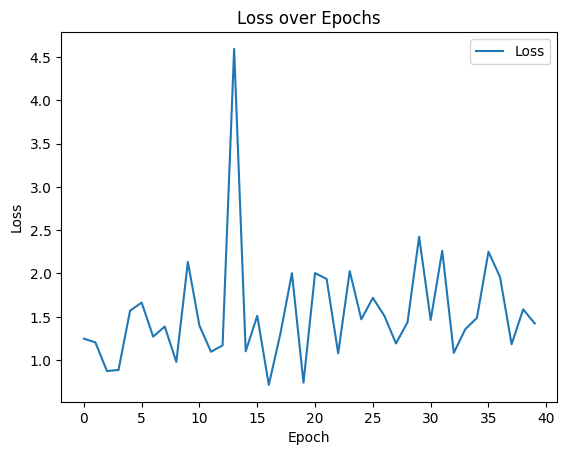

In [963]:
loss_list=[]
for i in losses:
    loss_list.append(i)

epochs = range(0, 40)

plt.plot(epochs, loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [107]:
torch.save(model.state_dict(), 'model1000.pt')


In [455]:
hidden_dim = 2
model2 = ToxicClassifier(node_dim, hidden_dim, 2)

In [453]:
print(model2.encoder.conv1)

GATConv(128, 1, heads=2)


In [456]:
model2.load_state_dict(torch.load("model72.pt"))

<All keys matched successfully>